In [2]:
import scvelo as scv

### Read in reference ADATA file for annotations

In [3]:
adata = scv.read("D:/Data/setd1a/3-scvelo/in/setd1a_b2.log1p_liger_med_singleR_noglyc.h5ad")

### Read in loom files

In [4]:
jz001_ds = scv.read("D:/Data/setd1a/3-scvelo/in/possorted_genome_bam_JZ001.loom")
jz004_ds = scv.read("D:/Data/setd1a/3-scvelo/in/possorted_genome_bam_JZ004.loom")

In [ ]:
# print(adata.obs[adata.obs['batch'] == "JZ004"])

In [5]:
# change barcodes to match with ref object
def change_barcode(myds,idx):
  ds = myds
  i = idx
  # change ds var index to match adata
  ds.var_names_make_unique()
  # remove loom prefix
  temp = ds.obs.index.str.split(':').str[1]
  # remove x from end of barcode
  temp2 =temp.str.split('x').str[0]
  # add sample number to end of barcode
  ds.obs.index = temp2+ "-" + str(i)
  ds.obs.index

change_barcode(jz001_ds, 1)
change_barcode(jz004_ds, 4)

In [6]:
final_loom = jz001_ds.concatenate(jz004_ds)

In [7]:
sel = adata[adata.obs["sampleID"].isin(["CT3", "FS3"])]

#### Merge with ref adata

In [8]:
adata = scv.utils.merge(sel, final_loom)

In [9]:
adata

AnnData object with n_obs × n_vars = 16541 × 21581
    obs: 'batch', 'condition', 'sampleID', 'n_counts_ribo_p', 'percent_mito', 'percent_ribo_p', 'n_counts', 'n_genes', 'sf', 'leiden', 'nowakowski_coarse', 'nowakowski_med', 'sample_batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'batch_colors', 'condition_colors', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_liger', 'X_umap'
    layers: 'counts', 'sf', 'matrix', 'ambiguous', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

## 1. RNA velocity analysis

In [10]:
scv.pp.moments(adata)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:14) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:10) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


### 1.1 Calculate velocity

In [11]:
scv.tl.umap(adata)
scv.tl.velocity(adata, mode = 'stochastic')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:20) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/16541 [00:00<?, ?cells/s]

    finished (0:02:33) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### 1.2 Dynamical model

In [12]:
scv.tl.recover_dynamics(adata, n_jobs = 8)
scv.tl.velocity(adata, mode = 'dynamical') # dynamical model, can change param
scv.tl.velocity_graph(adata)

# NOTE: for 64 GB/1 core on 5800X, usually takes around

recovering dynamics (using 8/16 cores)


  0%|          | 0/1769 [00:00<?, ?gene/s]

    finished (0:08:56) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:36) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/16541 [00:00<?, ?cells/s]

    finished (0:00:59) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [ ]:
adata.write("D:/Data/setd1a/3-scvelo/out/fs3_ct3_dynamical.h5ad") # after dynamical modelling

### 1.3 Identify important genes

In [13]:
scv.tl.rank_velocity_genes(adata, groupby='nowakowski_med', min_corr=.5) 
df = scv.DataFrame(adata.uns['rank_velocity_genes']['names']) 
df.head(n=10) 

ranking velocity genes
    finished (0:01:11) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


Astrocyte  Choroid    EN-PFC     EN-V1 Endothelial IN-CTX-CGE IN-CTX-MGE  \
0   ZFP36L1   ZNF462   SLC15A5   SLC15A5       STMN2      ZFHX3     BCL11B   
1    MAP4K4  SLC38A1      BMP7      LHX2       CELF4      ESRRG      ESRRG   
2      INTU    CELF2     FLRT2     KCNC2        RTN1     PPP3CA      ZFHX3   
3     EFNB2     RTN1      GRM1      NBEA        MAPT    NEUROD6     PPP3CA   
4    GABBR2  ZFP36L1     CBLN2      ANK3        SYT1     MGAT4C      MYT1L   
5     PGAP1    EFNB2     SLIT1     FLRT2     RUNX1T1      LUZP2     ATP8A2   
6      FAT4   MAP4K4      LHX2     SLIT1      GABRB3       GRM5      PCDH7   
7   GUCY1A2  ZNF385D  ARHGEF28      BMP7     ZFP36L1      TXNIP       ANK3   
8  ARHGAP21   COL4A5    ARID5B  ARHGAP20       LIN7A    FAM155A    FAM155A   
9    CORO2B    FLRT2     KCNC2     NDST3       NELL2      GAP43       GRM5   

    IN-STR IPC-div1 IPC-div2  ...      OPC RG-div1 RG-div2 RG-early       U1  \
0    ESRRG   TSPAN5   TSPAN5  ...    TMED9   FSTL1   FSTL1    PGAP1    PCDH7   
1   MGAT4C   GABBR2     NFIB  ...    ZFHX3  TSPAN5  RASSF8   MAP4K4     TCF4   
2   PPP3CA     NFIB    YIPF5  ...     PBX3   PALLD   GULP1     FZD3    MOB3B   
3  NEUROD6     FUT9     FUT9  ...    KANK4   PREX2   SEC63    ZFHX4      SLA   
4    LUZP2    ITGA2   BCL11A  ...   ARID5B   DMRT3  SEC31A     SYT1    LAMA1   
5  SLC2A13    STMN2    PGAP1  ...  TSPAN13  SEC31A    GLI3   ZNF462  SLC38A1   
6    TXNIP   BCL11A   CORO2B  ...  NEUROD6    TOX3  TSPAN5     FUT9    EFNB2   
7     NOL4    MEIS2    ITGA2  ...    LRRN3    LIPG    NFIB  ADAMTS9   ELAVL2   
8   PPFIA2     YAP1     CDH7  ...    NPTX2  KCNMB4   PGAP1    CERS6  ZNF385D   
9     GRM5   CORO2B   HS6ST2  ...    FOXP2    FZD3  CACHD1     INTU  RASGRP1   

  nEN-early nEN-late      nIN     tRG     vRG  
0      ANK3      VIM     SYT1  TGFBR2   PGAP1  
1     SYT16   PPP3CA     NEFM  MAP4K4  MAP4K4  
2     SYT14    ESRRG      VIM    TCF4    FZD3  
3   SLC17A6    ZFHX3   RBFOX3  ZNF462   ZFHX4  
4      NBEA     LMO3    STMN2   ZFHX4   CERS6  
5    PPFIA2     ANK3    CELF4    FZD3   PREX2  
6     SCN3B   ATP8A2   ZNF462   PGAP1  CACHD1  
7     KCNC2     CDH4    SYNE2    SYT1    ARF4  
8     SLIT1   MGAT4C  ZFP36L1    GSE1    FUT9  
9    PLXNA4     NEFM     CDH7  HS6ST2   CNTLN  

[10 rows x 25 columns]

In [14]:
scv.tl.rank_dynamical_genes(adata, groupby = "nowakowski_med")
scv.get_df(adata, 'rank_dynamical_genes/names').head(5)

ranking genes by cluster-specific likelihoods
    finished (0:00:13) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


Astrocyte Choroid  EN-PFC  EN-V1 Endothelial IN-CTX-CGE IN-CTX-MGE  IN-STR  \
0      WNT1  PRDM16    SYT1   ANK3      TRIM55       XPR1     SNAP25    SYT1   
1    SLC1A3    GJA1    RTN1   RTN1        GLI3       SYT1       TNIK  NMNAT2   
2      MAP2    YAP1    ANK3   SYT1        PCLO       NAV1       XPR1    RTN1   
3      NEO1  PLXDC2    DAB1   TCF4        GPC4     BCL11B        ARX    XPR1   
4      SYT1     BBX  BCL11B  SLIT1         ARX     NMNAT2      SSBP2  CTNNA2   

  IPC-div1 IPC-div2  ...      OPC RG-div1 RG-div2 RG-early         U1  \
0     NFIB    ASF1B  ...     XPR1    EXO1   MCM10     GLI3       TNIK   
1     PIF1      CPE  ...   PPP3CA    PIF1    GLI3   SLC1A3      MYO10   
2    SSBP2     NFIB  ...  FAM155A   ASF1B   MYBL2     TCF4  LINC02621   
3      CPE    SSBP2  ...   SNAP25   MYBL2   SSBP2     DOK5       NEO1   
4    MYO10   TSPAN5  ...    CELF4     ID4   SALL1    SSBP2      SSBP2   

  nEN-early nEN-late     nIN    tRG     vRG  
0   EPB41L3  RUNX1T1  ADGRL3   SYT1    GLI3  
1     DCLK1     SYT1   NOVA1   TCF4    TCF4  
2     PRKCE   CSRNP3   NCAM1  SSBP2    YAP1  
3      XPR1    DCLK1     ARX   GLI3  TCF7L1  
4      RTN1    NCAM1    MAP2   YAP1   SSBP2  

[5 rows x 25 columns]

### 1.4 Latent time

In [18]:
scv.tl.recover_dynamics(adata, n_jobs = 12)
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color = 'latent_time', color_map = 'gnuplot', size = 80)

recovering dynamics (using 12/16 cores)


  0%|          | 0/1091 [00:00<?, ?gene/s]

KeyboardInterrupt: 

In [14]:
adata.write("D:/Data/setd1a/3-scvelo/out/fs3_ct3_dynamical.h5ad") # after latent time

### 1.4.1 Exporting data for Monocle3 analysis

In [3]:
adata = scv.read('D:/Data/setd1a/3-scvelo/in/setd1a_b2.log1p_liger_med_singleR_noglyc.h5ad')

In [4]:
data_sel = adata[adata.obs["sampleID"].isin(["CT3", "FS3"])]

In [5]:
var_mon = data_sel.var.copy()
obs_mon = data_sel.obs.copy()

var_mon.to_csv('D:/Data/setd1a/5-seurat/in/var_mon.csv')
obs_mon.to_csv('D:/Data/setd1a/5-seurat/in/obs_mon.csv')

# export preprocessed counts needed by monocle3 in R. It will take ~10 minutes for data_mat.
data_sel.to_df().to_csv('D:/Data/setd1a/5-seurat/in/data_mat_final_mon.csv')

### 1.4 Generate all plots
Each plot is contained in a separate cell.

In [7]:
# adata = scv.read("D:/Data/setd1a/3-scvelo/out/fs3_ct3_dynamical.h5ad")
adata.obs

batch condition sampleID  n_counts_ribo_p  percent_mito  \
AAACCCAAGCGCTGCT  JZ001        CT      CT3             89.0      0.063260   
AAACCCACACGGCTAC  JZ001        CT      CT3            336.0      0.056995   
AAACCCACAGCGTTGC  JZ001        CT      CT3            591.0      0.039846   
AAACCCACATGAAGGC  JZ001        CT      CT3           1292.0      0.125363   
AAACCCACATGACTCA  JZ001        CT      CT3             70.0      0.118056   
...                 ...       ...      ...              ...           ...   
TTTGTTGCAATTGCAC  JZ004        FS      FS3           1241.0      0.060242   
TTTGTTGCACGAAGAC  JZ004        FS      FS3           1350.0      0.011033   
TTTGTTGCATGACGTT  JZ004        FS      FS3           1382.0      0.046941   
TTTGTTGCATTGCTGA  JZ004        FS      FS3            996.0      0.052377   
TTTGTTGTCTTGCAAG  JZ004        FS      FS3            252.0      0.089829   

                  percent_ribo_p     n_counts  n_genes        sf leiden  ...  \
AAACCCAAGCGCTGCT        0.072182   788.375244      750  0.176090      4  ...   
AAACCCACACGGCTAC        0.290155   816.993286      703  0.139674      0  ...   
AAACCCACAGCGTTGC        0.126607  1668.536743     2414  0.740848      1  ...   
AAACCCACATGAAGGC        0.267717  1451.303223     1694  0.499742      1  ...   
AAACCCACATGACTCA        0.162037   437.887146      329  0.065410      0  ...   
...                          ...          ...      ...       ...    ...  ...   
TTTGTTGCAATTGCAC        0.099415  2114.106445     4501  2.042937      5  ...   
TTTGTTGCACGAAGAC        0.209790  1779.794800     2827  0.972318     18  ...   
TTTGTTGCATGACGTT        0.095120  2193.123779     5095  2.492770      5  ...   
TTTGTTGCATTGCTGA        0.104754  1913.081055     4005  1.824375      3  ...   
TTTGTTGTCTTGCAAG        0.073022  1440.056152     1955  0.623640      9  ...   

                 nowakowski_med sample_batch initial_size_spliced  \
AAACCCAAGCGCTGCT        RG-div2           -1                 1325   
AAACCCACACGGCTAC      nEN-early           -1                 1209   
AAACCCACAGCGTTGC          EN-V1           -1                 4193   
AAACCCACATGAAGGC        IPC-nEN           -1                 5122   
AAACCCACATGACTCA        Choroid           -1                  527   
...                         ...          ...                  ...   
TTTGTTGCAATTGCAC          EN-V1           -4                 9686   
TTTGTTGCACGAAGAC       RG-early           -4                 4914   
TTTGTTGCATGACGTT          EN-V1           -4                11116   
TTTGTTGCATTGCTGA        IPC-nEN           -4                 7234   
TTTGTTGTCTTGCAAG         IN-STR           -4                 3135   

                  initial_size_unspliced  initial_size  \
AAACCCAAGCGCTGCT                    2093        1325.0   
AAACCCACACGGCTAC                     150        1209.0   
AAACCCACAGCGTTGC                    4128        4193.0   
AAACCCACATGAAGGC                     326        5122.0   
AAACCCACATGACTCA                     117         527.0   
...                                  ...           ...   
TTTGTTGCAATTGCAC                    8298        9686.0   
TTTGTTGCACGAAGAC                    3315        4914.0   
TTTGTTGCATGACGTT                   10215       11116.0   
TTTGTTGCATTGCTGA                    6673        7234.0   
TTTGTTGTCTTGCAAG                    2458        3135.0   

                  velocity_self_transition    root_cells    end_points  \
AAACCCAAGCGCTGCT                  0.268786  3.216127e-02  3.351497e-06   
AAACCCACACGGCTAC                  0.023670  3.833239e-04  1.620340e-02   
AAACCCACAGCGTTGC                  0.538720  8.656080e-06  6.631317e-02   
AAACCCACATGAAGGC                  0.527631  1.601085e-02  3.515250e-05   
AAACCCACATGACTCA                  0.402941  5.012777e-06  2.615431e-02   
...                                    ...           ...           ...   
TTTGTTGCAATTGCAC                  0.488327  2.293168e-06  7.339958e-01   
TTTGTTGCACGAAG

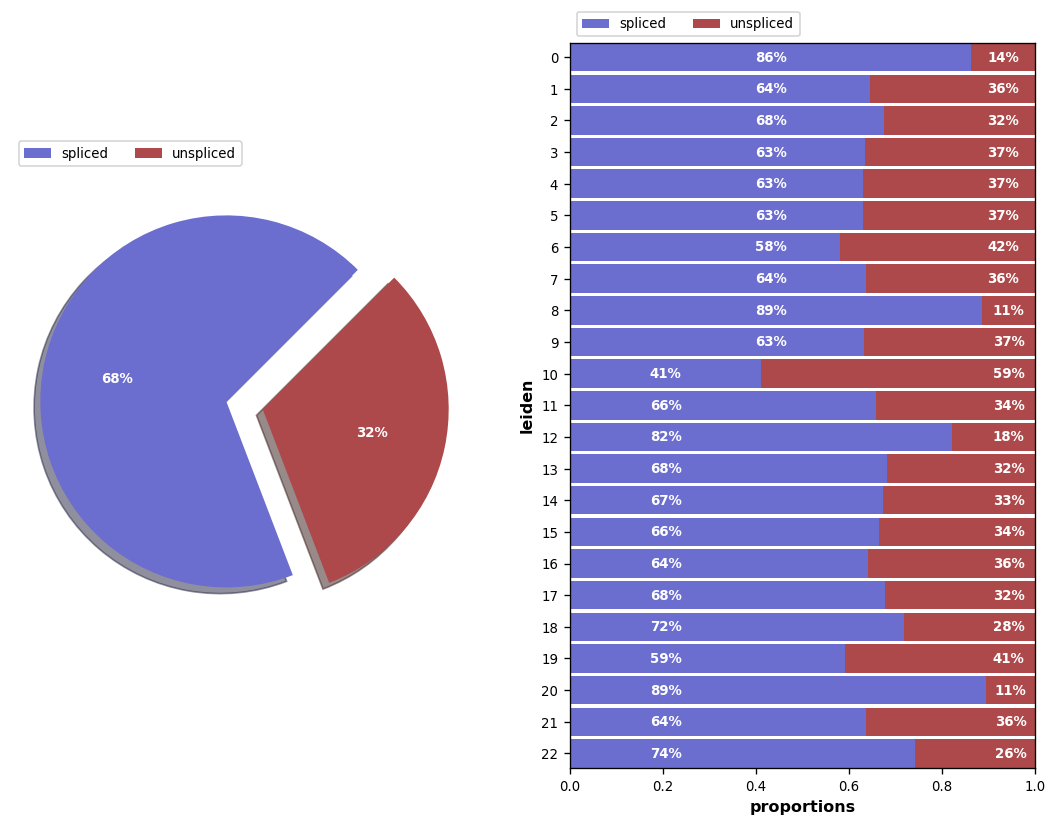

In [4]:
scv.pl.proportions(adata, groupby = "leiden", dpi = 120, figsize = (11, 8))

computing velocity embedding
    finished (0:00:03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


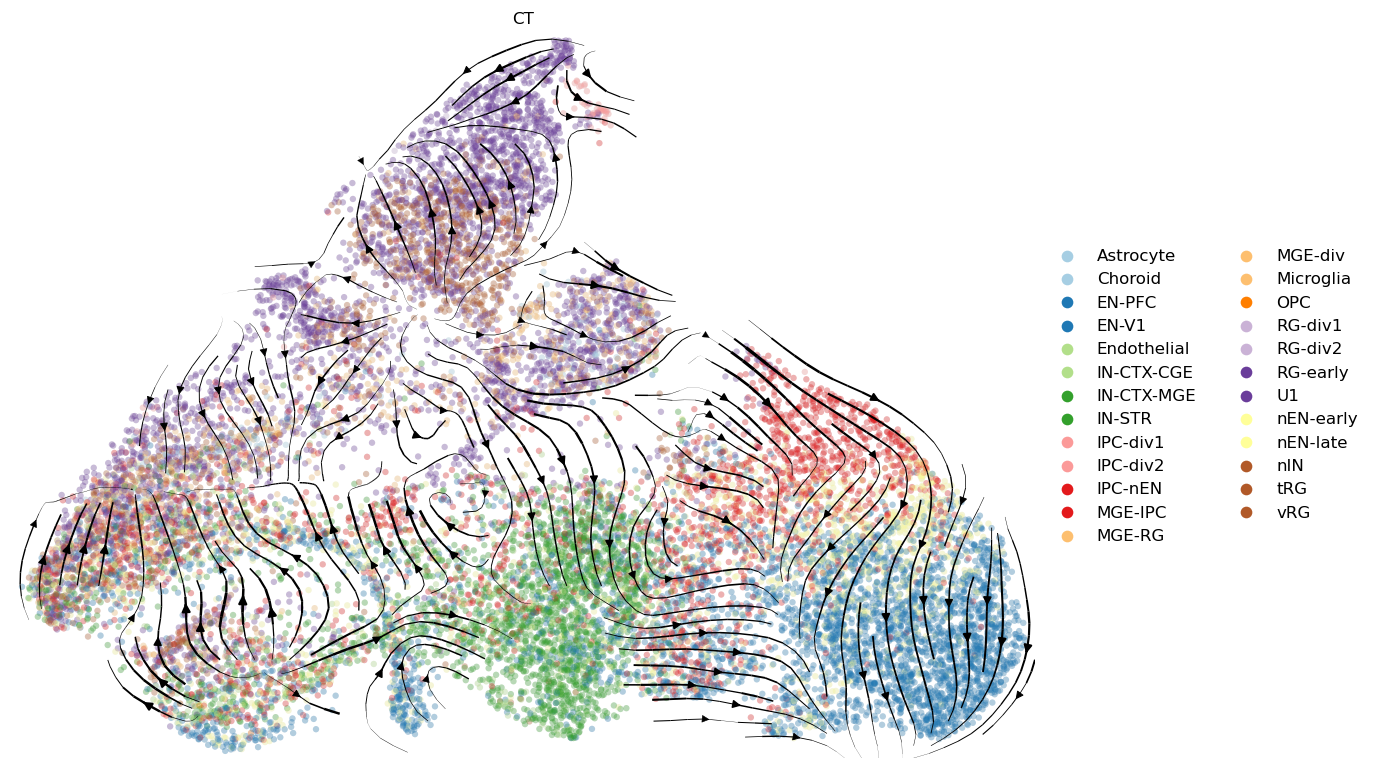

In [5]:
ID = 'CT'
scv.pl.velocity_embedding_stream(adata,legend_loc='right',alpha=0.3,title=ID,palette='Paired', color = 'nowakowski_med',dpi=120, figsize=(11,8) ) 

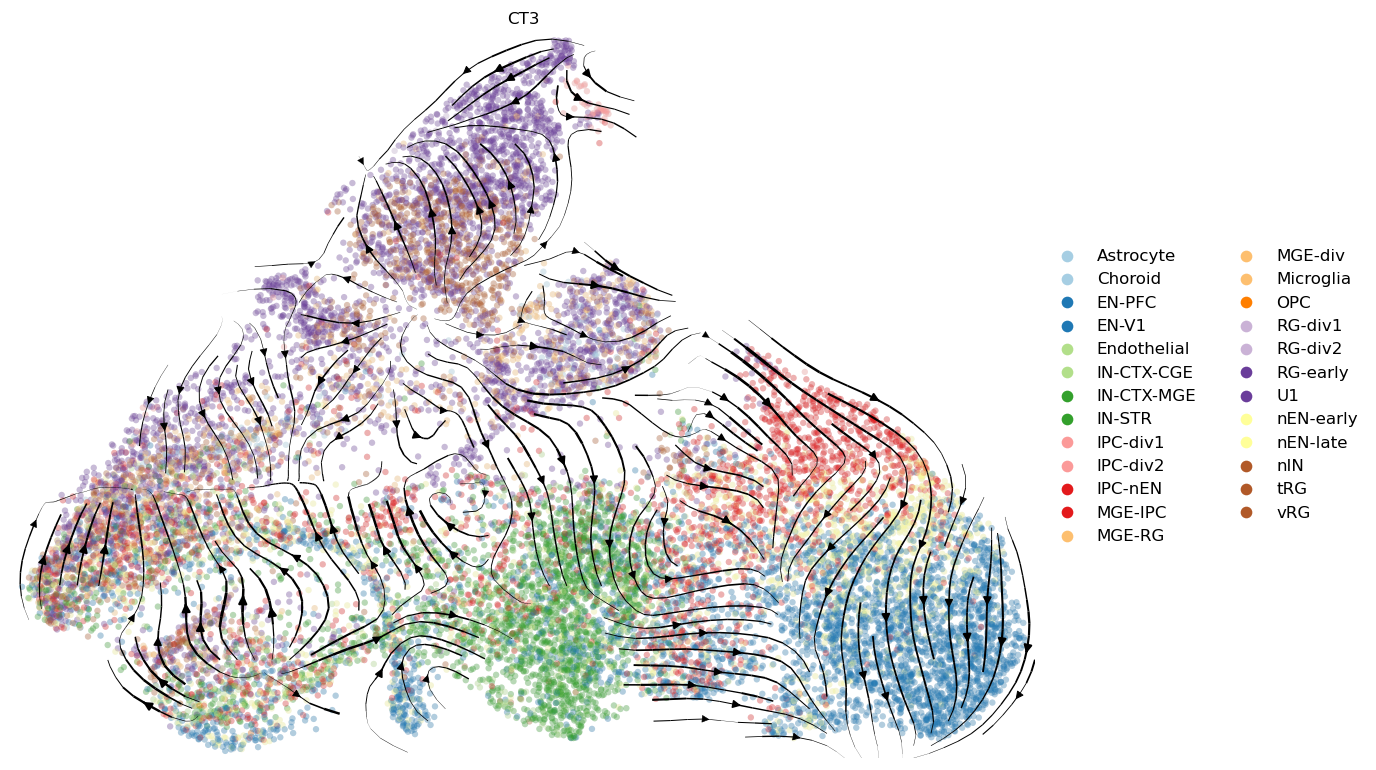

In [10]:
sample_id = 'CT3'
scv.pl.velocity_embedding_stream(adata,legend_loc='right',alpha=0.3,title=sample_id,palette='Paired', color = 'nowakowski_med',dpi=120, figsize=(11,8) ) 

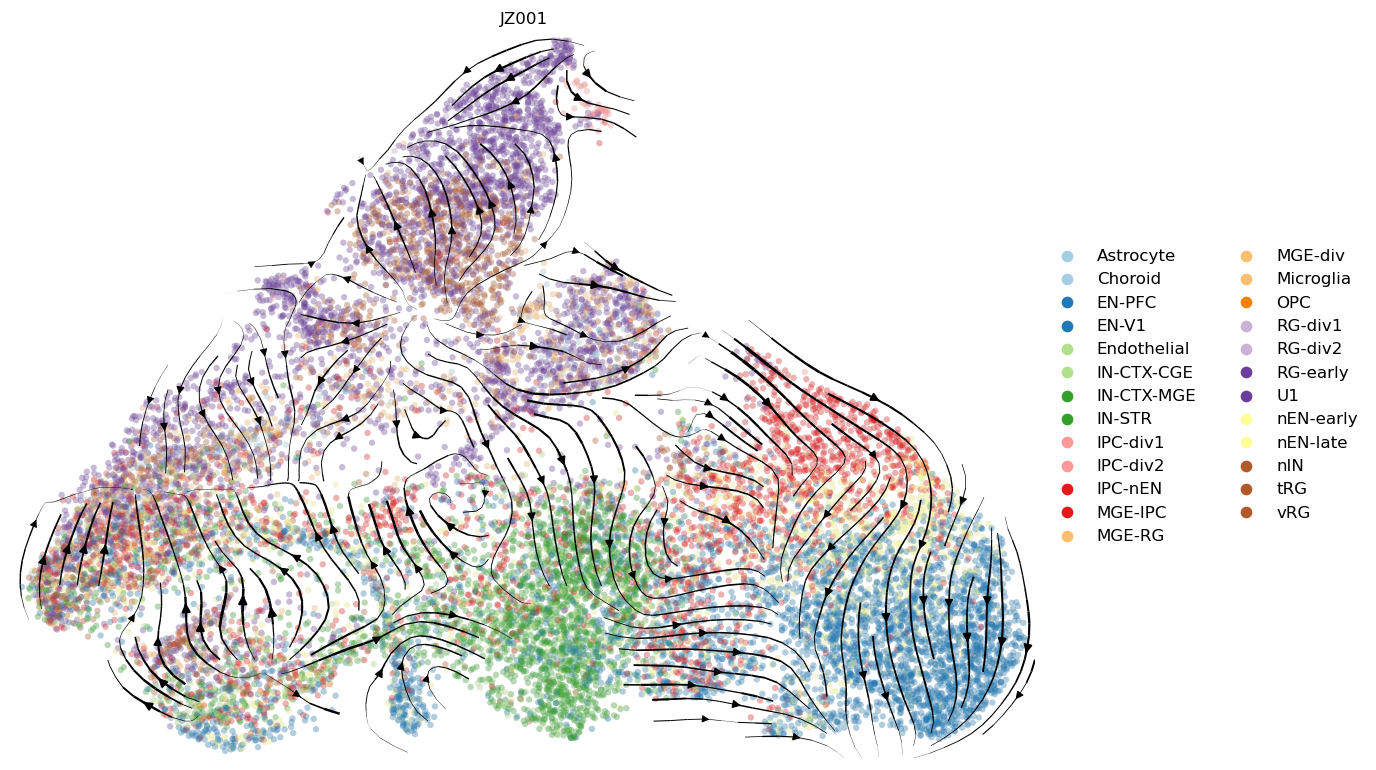

In [13]:
scv.pl.velocity_embedding_stream(adata,legend_loc='right',alpha=0.3,title="JZ001",palette='Paired', color = 'nowakowski_med',dpi=120, figsize=(11,8)) 